In [655]:
%run feature_extraction.ipynb

1.6597412693274927e-110
4.2552940390803975e-123


In [656]:
# imports
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import tqdm
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import torch

In [657]:
#imports
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [658]:
# reading train data
train_1=pd.read_pickle('output/train_3_original.pkl')

In [659]:
# reading dev data
dev_1=pd.read_pickle('output/dev_1_original.pkl')

In [660]:
#check reading is fine
train_1.head(10)


,text,category,stance,tokens
3,#تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...,celebrity,2,"[وزر, صحة, فخر, دين, قوج, لقى, اول, جرع, لقح, ..."
4,وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...,personal,1,"[وئم, وهب, شتم, دول, خلج, طلة, علم, تسف, علي, ..."
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
6,لبنان اشترى مليونان لقاح امريكي اذا شلنا يلي ع...,info_news,2,"[لبن, شرى, لين, لقح, امر, اذا, شلن, يلي, عمر, ..."
9,دعبول حضرتك منو انت وتطلب من قائد دولة إسلامية...,info_news,2,"[دعبول, حضر, منو, انت, طلب, قئد, دول, سلم, لقح..."
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"


In [661]:
# change  category to be int
def edit_categories(x):
    if x == 'info_news':
        return 0
    elif x == 'celebrity':
        return 1
    elif x == 'plan':
        return 2
    elif x == 'requests':
        return 3
    elif x == 'rumors':
        return 4
    elif x == 'advice':
        return 5
    elif x == 'restrictions':
        return 6
    elif x == 'personal':
        return 7
    elif x == 'unrelated':
        return 8
    elif x == 'others':
        return 9
    else:
        return -1

In [662]:
# passing values for train
sentences_train,stance_train,category_train =train_1.loc[:,"tokens"],train_1.loc[:,"stance"],train_1.loc[:,"category"].apply(edit_categories)

In [663]:
#passing values for test
sentences_dev,stance_dev,category_dev =dev_1.loc[:,"tokens"],dev_1.loc[:,"stance"],dev_1.loc[:,"category"].apply(edit_categories)

In [664]:
#check passing is fine
print(len(sentences_train),len(category_train),len(stance_train))

3000 3000 3000


In [665]:
#check passing is fine
print(len(sentences_dev),len(category_dev),len(stance_dev))

1000 1000 1000


In [666]:
new_sentences_train=[]
new_sentences_dev=[]
# merge tokens to be sentences to can be used in some features
for sentence in sentences_train:
    new_sentences_train.append(' '.join(sentence))
for sentence in sentences_dev:
    new_sentences_dev.append(' '.join(sentence))

In [667]:
# for tf-idf , you should send sentences
def preprocessing_tf_ifd(sentences):
    new_sentences=[]
    for sentence in sentences:
        new_sentences.append(' '.join(sentence))
    return new_sentences


In [668]:
#get  new_sentences_train
new_sentences_train=preprocessing_tf_ifd(sentences_train)

In [669]:
#get tf -idf for training dta 

dict_res_train,tfIdf,tf_idf_train,tfIdfVectorizer=get_TF_IDF(new_sentences_train)

c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [670]:
print(len(tf_idf_train[0]))

4485


In [671]:
# get unique words in training which is used in tf -df
unique_words_train= tfIdfVectorizer.get_feature_names()

In [672]:
print(len(unique_words_train))

4485


In [673]:
# for test or dev data , assume some words are new , so change them with word in train
#choosing word is important , currently i random it with word has good probabitiy 
def change_test_set(sentences_dev, unique_words_train, changed_word ='قوة'):
    new_sentences=[]
    for sentence in sentences_dev:
        new_sentence=[]
        for word in sentence:
            if ( word not in unique_words_train):
                word = changed_word
            new_sentence.append(word)
        new_sentences.append(new_sentence)
    return new_sentences

In [674]:
#change sentences of dev for tf -idf 
# don't use them for n gram , in ngram i am doing smoothing
sentences_dev_removed=change_test_set(sentences_dev,unique_words_train)

In [675]:

new_sentences_dev_removed=[]
#using new sentences of dev after removing new words by existing word
# then convert tokens to sentences
for sentence in sentences_dev_removed:
    new_sentences_dev_removed.append(' '.join(sentence))
tf_idf_dev=[]
# using the same transformer in testing data
tfIdf=tfIdfVectorizer.fit_transform(new_sentences_dev_removed)
# here i get tf -idf for test
for i in range(0,len(new_sentences_dev_removed)):
        df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
        dict_res= preprocessing_tf_idf(i,tfIdfVectorizer,tfIdf)
        tf_idf_currrent =[]
        #here making sure the tf -idf for test with the same size of train
        for word in unique_words_train:
            if word in dict_res:
                tf_idf_currrent.append(dict_res[word])
            else:
                tf_idf_currrent.append(0.0)
        tf_idf_dev.append(tf_idf_currrent)


In [676]:
print(len(tf_idf_dev[0]))

4485


In [677]:
# converting all to lists
for i  in range(0,len(tf_idf_train)):
    tf_idf_train[i]= list(tf_idf_train[i])
for i in range(0,len(tf_idf_dev)):
    tf_idf_dev[i]= list(tf_idf_dev[i])

In [678]:
#check they are the same
print(len(tf_idf_dev[0]), len(tf_idf_train[0]))

4485 4485


In [679]:
#get n gram for data
prob_dev = convert_ngrams_probablities( 2,new_sentences_dev)
prob_train = convert_ngrams_probablities( 2,new_sentences_train)

In [681]:
print(len(prob_dev),len(prob_train))

1000 3000


In [682]:
#currently i am using one feature change it when u want
feature_train = tf_idf_train
feature_dev =tf_idf_dev

In [683]:
# Get CBOW & Skip Gram Features for training and dev
X_train_cbow_w2v, X_train_sg_w2v = get_word_embeddings_features(sentences_train)
X_dev_cbow_w2v, X_dev_sg_w2v = get_word_embeddings_features(sentences_dev)

In [684]:
min_x_train_cbow =abs(np.min(X_train_cbow_w2v))
min_x_dev_cbow= abs(np.min(X_dev_cbow_w2v))
min_x_train_sg = abs(np.min(X_train_sg_w2v))
min_x_dev_sg = abs(np.min(X_dev_sg_w2v))

In [685]:
len(X_train_cbow_w2v[0])

100

In [686]:
X_dev_cbow_w2v[0].shape

(100,)

In [687]:
feature_train=np.array(prob_train).reshape(-1,1)
feature_dev=np.array(prob_dev).reshape(-1,1)
# for i in range(0, len(sentences_train)):
#     new_tf_idf_train= tf_idf_train[i]
#     new_tf_idf_train.append(prob_train[i])
#     new_feature= new_tf_idf_train
#     # new_feature = np.concatenate((new_feature,X_train_sg_w2v[i]+min_x_train_sg))
#     feature_train.append(new_feature)
# for i in range(0,len(sentences_dev)):
#     new_tf_idf_dev=tf_idf_dev[i]
#     new_tf_idf_dev.append(prob_dev[i])
#     feature_dev.append(new_feature)


In [688]:
len(prob_train)

3000

In [689]:
#models imports
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from  matplotlib import pyplot 

In [690]:
values =np.linspace(1, 1000, num=1000)

In [691]:
# Boost 100 weak decision trees

n_estimators = [50, 100, 150, 200, 250, 300, 350]
train_scores=[]
test_scores=[]
for val in n_estimators:
    model = RandomForestClassifier(n_estimators=val)
    model = model.fit(feature_train, stance_train)
    predictions = model.predict(feature_dev)
    acc = {metrics.accuracy_score(stance_dev, predictions) * 100}
    print(f" Model Accuracy is {acc}")
    print(len(predictions[stance_dev==0]))
    print(len(predictions[stance_dev==1]))
    print(len(predictions[stance_dev==2]))
    # print(metrics.classification_report(stance_dev,predictions))
    train_score = accuracy_score(stance_train,model.predict(feature_train))
    train_scores.append(train_score)
    test_score = accuracy_score(stance_dev,model.predict(feature_dev))
    test_scores.append(test_score)

 Model Accuracy is {77.2}
70
126
804
 Model Accuracy is {77.4}
70
126
804
 Model Accuracy is {77.4}
70
126
804
 Model Accuracy is {77.3}
70
126
804
 Model Accuracy is {7.7}
70
126
804
 Model Accuracy is {7.5}
70
126
804
 Model Accuracy is {77.3}
70
126
804


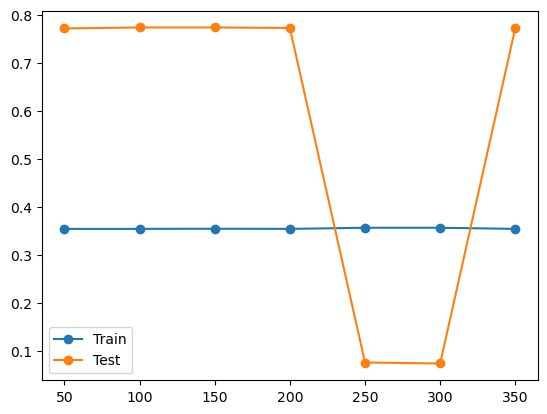

In [692]:
# plot of train and test scores vs tree depth
pyplot.plot(n_estimators, train_scores, '-o', label='Train')
pyplot.plot(n_estimators, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [693]:
print(metrics.classification_report(stance_dev,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.09      0.02      0.04       126
           2       0.80      0.96      0.87       804

    accuracy                           0.77      1000
   macro avg       0.30      0.33      0.30      1000
weighted avg       0.65      0.77      0.71      1000



In [694]:
cm = confusion_matrix(stance_dev, predictions)


In [695]:
print(cm)

[[  0   1  69]
 [  0   3 123]
 [  4  30 770]]


In [696]:
# Boost 100 weak decision trees
model = RandomForestClassifier(n_estimators=100)
#GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

model = model.fit(feature_train, category_train)

In [697]:
predictions = model.predict(feature_dev)
acc = {metrics.accuracy_score(category_dev, predictions) * 100}
train_score = accuracy_score(category_train,model.predict(feature_train))
print("train accuarcy", train_score)
print(f" Model Accuracy is {acc}")

train accuarcy 0.5126666666666667
 Model Accuracy is {53.400000000000006}


In [698]:
print(metrics.classification_report(category_dev,predictions))

              precision    recall  f1-score   support

           0       0.55      0.98      0.70       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00       128
           8       0.05      0.03      0.04        36
           9       0.11      0.06      0.08        17

    accuracy                           0.53      1000
   macro avg       0.07      0.11      0.08      1000
weighted avg       0.30      0.53      0.39      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [699]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [700]:
import time
from sklearn import svm,metrics


classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(feature_train, stance_train)

predictions  = classifier_linear.predict(feature_dev)
train_score = accuracy_score(stance_train,classifier_linear.predict(feature_train))
print("train accuarcy", train_score)
print(metrics.accuracy_score(stance_dev, predictions) * 100)



train accuarcy 0.33666666666666667
80.0


In [701]:
print(metrics.classification_report(stance_dev,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.14      0.01      0.02       126
           2       0.80      0.99      0.89       804

    accuracy                           0.80      1000
   macro avg       0.32      0.33      0.30      1000
weighted avg       0.66      0.80      0.72      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [702]:

classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(feature_train, category_train)
predictions  = classifier_linear.predict(feature_dev)
train_score = accuracy_score(category_train,classifier_linear.predict(feature_train))
print("train accuarcy", train_score)
print(metrics.accuracy_score(category_dev, predictions) * 100)


train accuarcy 0.497
54.50000000000001


In [703]:
print(metrics.classification_report(category_dev,predictions))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00       128
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        17

    accuracy                           0.55      1000
   macro avg       0.05      0.10      0.07      1000
weighted avg       0.30      0.55      0.38      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [704]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(feature_train, stance_train)

In [705]:
predicted = clf.predict(feature_dev)
# Model Accuracy, how often is the classifier correct?
train_score = accuracy_score(stance_train,clf.predict(feature_train))
print("train accuarcy", train_score)
print("Accuracy:",metrics.accuracy_score(stance_dev, predicted)*100)
print(len(predicted[stance_dev==0]))
print(len(predicted[stance_dev==1]))
print(len(predicted[stance_dev==2]))

train accuarcy 0.3333333333333333
Accuracy: 7.000000000000001
70
126
804


In [706]:
print(metrics.classification_report(stance_dev,predicted))

              precision    recall  f1-score   support

           0       0.07      1.00      0.13        70
           1       0.00      0.00      0.00       126
           2       0.00      0.00      0.00       804

    accuracy                           0.07      1000
   macro avg       0.02      0.33      0.04      1000
weighted avg       0.00      0.07      0.01      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [707]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(feature_train, category_train)

In [708]:
predicted = clf.predict(feature_dev)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(category_dev, predicted)*100)
train_score = accuracy_score(category_train,clf.predict(feature_train))
print("train accuarcy", train_score)

Accuracy: 54.50000000000001
train accuarcy 0.497


In [709]:
print(metrics.classification_report(category_dev,predicted))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00       128
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        17

    accuracy                           0.55      1000
   macro avg       0.05      0.10      0.07      1000
weighted avg       0.30      0.55      0.38      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [ ]:
# kf =KFold(n_splits=10, shuffle=True, random_state=42)

# cnt = 1
# # split()  method generate indices to split data into training and test set.
# for train_index, test_index in kf.split(features, stance):
#     print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
#     cnt += 1

In [ ]:
model = RandomForestClassifier(n_estimators=300)

In [ ]:
# n_estimators = [50, 100, 150, 200, 250, 300, 350]

# for val in n_estimators:
#     score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42) ,features, stance, cv= kf, scoring="accuracy")
#     print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

In [ ]:
# n_estimators = [50, 100, 150, 200, 250, 300, 350]

# for val in n_estimators:
#     score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42) ,features, category, cv= kf, scoring="accuracy")
#     print(f'Average score({val}): {"{:.3f}".format(score.mean())}')


In [710]:
from sklearn.linear_model import LogisticRegression

In [711]:
#Fitting The Stance Detection Model using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(feature_train, stance_train)  #model

#Predict y value for test dataset
stance_predict = lr_w2v.predict(feature_dev)
stance_prob = lr_w2v.predict_proba(feature_dev)[:,1]
print("Accuracy:",metrics.accuracy_score(stance_dev, stance_predict)*100)
print(metrics.classification_report(stance_dev,stance_predict))

# Fitting The Classification Model using Logistic Regression (W2v)
lr_w2v2=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v2.fit(feature_train, category_train)  #model

#Predict y value for test dataset
categ_predict = lr_w2v2.predict(feature_dev)
print("Accuracy:",metrics.accuracy_score(category_dev, categ_predict)*100)
print(metrics.classification_report(category_dev,categ_predict))
categ_prob = lr_w2v2.predict_proba(feature_dev)[:,1]

Accuracy: 79.7
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.10      0.01      0.01       126
           2       0.80      0.99      0.89       804

    accuracy                           0.80      1000
   macro avg       0.30      0.33      0.30      1000
weighted avg       0.66      0.80      0.72      1000

Accuracy: 54.50000000000001
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00       128
           8       0.00      0.00      0.00        36
           9       0.00      0.00  

c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,